In [13]:
import numpy as np
import cv2
import threading
import sounddevice as sd
import time, os
import matplotlib.pyplot as plt
import logging
import collections

In [14]:
BGR_COLOR = {
    'red': (0,0,255),
    'green': (127,255,0),
    'blue': (255,127,0),
    'yellow': (0,127,255),
    'black': (0,0,0),
    'white': (255,255,255)
}

In [15]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [16]:
class FPSTimes:
    
    def __init__(self, buffer=1000):
        self.frame_times = []
        self.buffer = buffer
        
    def count(self):
        self.frame_times.append(time.time())
        if len(self.frame_times) > self.buffer:
            self.frame_times.pop(0)
        
    def get_time_diffs(self):
        return np.diff(np.array(self.frame_times))
        
    def get_avg_fps(self):
        diffs = self.get_time_diffs()
        if len(diffs) > 0:
            return (1.0/diffs).mean()
        return 0

In [17]:
class WebcamStream(FPSTimes):
    # check camera output formats with FFMPEG
    # https://stackoverflow.com/questions/15301608/how-to-query-a-webcams-output-formats
    #
    # ffmpeg -list_devices true -f dshow -i dummy
    # ffmpeg -list_options true -f dshow -i video="HD USB Camera"
    
    default_cfg = {
        'source': 0,
        'frame_width': 1024,
        'frame_height': 768,
        'fps': 20,
        'api': '',  # 700 -> cv2.CAP_DSHOW
        'verbose': True,
    }
    
    def __init__(self, cfg):
        super(WebcamStream, self).__init__()
        
        self.cfg = cfg
        
        # preparing a MPEG video stream
        self.stream = cv2.VideoCapture(src, cfg['api']) if cfg['api'] else cv2.VideoCapture(cfg['source'])
        self.stream.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc('M', 'J', 'P', 'G'))
        self.stream.set(cv2.CAP_PROP_FRAME_WIDTH, cfg['frame_width'])
        self.stream.set(cv2.CAP_PROP_FRAME_HEIGHT, cfg['frame_height'])
        self.stream.set(cv2.CAP_PROP_FPS, cfg['fps'])
        self.stream.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc('M', 'J', 'P', 'G'))  # cv2.VideoWriter_fourcc('H', '2', '6', '4')

        if cfg['verbose']:
            print("W:H - %s:%s" % (self.stream.get(cv2.CAP_PROP_FRAME_WIDTH), self.stream.get(cv2.CAP_PROP_FRAME_HEIGHT)))
            print("FPS: %s" % self.stream.get(cv2.CAP_PROP_FPS))
            print(self.stream.get(cv2.CAP_PROP_FOURCC))
            print(self.stream.get(cv2.CAP_PROP_BACKEND))
        
        self.frame = None
        self.stopped = False
        
    def start(self):
        self._th = threading.Thread(target=self.update, args=())
        self._th.start()

    def stop(self):
        self.stopped = True
        time.sleep(0.5)   # wait until device is released
        self._th.join()
        print('Camera released')
            
    def update(self):
        while not self.stopped:
            (self.grabbed, self.frame) = self.stream.read()
            self.count()  # count FPS
        self.stream.release()
            
    def read(self):
        return self.frame

In [18]:
class VideoWriter(FPSTimes):
    # precise timing https://stackoverflow.com/questions/42565297/precise-loop-timing-in-python
    
    default_cfg = {
        'fps': 20,
        'file_path': 'test_video.avi',
    }
    
    def __init__(self, video_stream, cfg):
        super(VideoWriter, self).__init__()
        
        self.cfg = cfg
        self.video_stream = video_stream  # cv2 video stream
        self.stopped = False
        
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        res_x, res_y = int(video_stream.stream.get(3)), int(video_stream.stream.get(4))
        self.out = cv2.VideoWriter(cfg['file_path'], fourcc, cfg['fps'], (res_x, res_y))

    @property
    def latency(self):
        return 1.0/self.cfg['fps']
        
    def start(self):
        self._th = threading.Thread(target=self.update, args=())
        self._th.start()
    
    def stop(self):
        self.stopped = True
        time.sleep(0.5)   # wait until device is released
        self._th.join()
        print('Video writer stopped')
        
    def update(self):
        next_frame = time.time() + self.latency
        
        while not self.stopped:
            if time.time() < next_frame:
                continue

            frame = self.video_stream.read()
            if frame is not None:
                self.count()  # count FPS
                self.out.write(frame)
                
                frames_missed = np.floor((time.time() - next_frame) * self.cfg['fps'])
                next_frame += self.latency * frames_missed + self.latency
            
        self.out.release()

In [19]:
class PositionTracker(FPSTimes):

    default_cfg = {
        'background_file': 'background.png',
        'arena_x': 512,
        'arena_y': 384,
        'arena_radius': 350
    }
    
    def __init__(self, video_stream, cfg):
        super(PositionTracker, self).__init__()
        
        self.cfg = cfg
        self.video_stream = video_stream
        self.background = cv2.imread(cfg['background_file'], 1)

        self.x, self.y = None, None
        self.contour = []
        self.stopped = False
        
        self.mask = np.zeros(shape=self.background.shape, dtype="uint8")
        cv2.circle(self.mask, (cfg['arena_x'], cfg['arena_y']), cfg['arena_radius'], BGR_COLOR['white'], -1)

    def start(self):
        self._th = threading.Thread(target=self.update, args=())
        self._th.start()
    
    def stop(self):
        self.stopped = True
        time.sleep(0.1)
        self._th.join()
        print('Position tracker stopped')
        
    def update(self):
        while not self.stopped:
            frame = self.video_stream.read()
            if frame is not None:
                self.count()  # count FPS
                self.detect_position(frame)
       
    def detect_position(self, frame):
        masked_frame = cv2.bitwise_and(src1=frame, src2=self.mask)

        # Substracts background from current frame
        subject = cv2.subtract(masked_frame, self.background)

        # Converts subject to grey scale
        subject_gray = cv2.cvtColor(subject, cv2.COLOR_BGR2GRAY)

        # Applies blur and thresholding to the subject
        kernel_size = (25,25)
        frame_blur = cv2.GaussianBlur(subject_gray, kernel_size, 0)
        _, thresh = cv2.threshold(frame_blur, 40, 255, cv2.THRESH_BINARY)

        # Finds contours and selects the contour with the largest area
        contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

        if len(contours) == 0:
            return
        contour = contours[np.argmax(list(map(cv2.contourArea, contours)))]
        M = cv2.moments(contour)
        if (M['m00'] == 0):
            return

        self.x = int(M['m10'] / M['m00'])
        self.y = int(M['m01'] / M['m00'])
        self.contour = contour

In [20]:
class SoundController(FPSTimes):
    
    default_cfg = {
        'frequencies': [440, 880, 6000],
        'pulse_duration': 0.05,
        'sample_rate': 44100,
        'latency': 0.25,
        'log_file': 'sound_log.csv'
    }
    
    def __init__(self, cfg):
        super(SoundController, self).__init__()

        #sd.default.samplerate = cfg['sample_rate']
        #sd.default.device = 20  # set the device id
        self.stopped = False
        self.cfg = cfg         # sound settings
        self.actual_sound = 0  # current sound to play
        with open(self.cfg['log_file'], 'w') as f:  # refresh log file
            f.write('time,sound_id\n')

        # Initialize sounds
        silence = np.zeros(int(cfg['pulse_duration'] * cfg['sample_rate']), dtype='float32')
        self.sounds = {
            0: np.column_stack((silence, silence))
        }
        for i, freq in enumerate(cfg['frequencies']):
            tone = SoundController.get_pure_tone(freq, cfg['pulse_duration'], cfg['sample_rate']) * 0.75
            
            # TODO add tone onset offset
            
            self.sounds[i + 1] = np.column_stack((tone, tone))
        
        # Initialize sound stream
        self.stream = sd.OutputStream(samplerate=cfg['sample_rate'], channels=2, dtype='float32')

    @staticmethod
    def get_pure_tone(freq, duration, sample_rate=44100):
        x = np.linspace(0, duration * freq * 2*np.pi, int(duration*sample_rate), dtype=np.float32)
        return np.sin(x)

    def log_event(self, t_event, sound_id):
        with open(self.cfg['log_file'], 'a') as f:
            f.write(",".join([str(x) for x in (t_event, sound_id)]) + "\n")
        
    def start(self):
        self.stream.start()

        self._th = threading.Thread(target=self.update, args=())
        self._th.start()
    
    def stop(self):
        self.stopped = True
        time.sleep(0.3)
        self._th.join()
        print('Sound controller stopped')

    def update(self):
        next_beat = time.time() + self.cfg['latency']
        
        while not self.stopped:
            t0 = time.time()
            if t0 < next_beat:
                continue
                
            self.count()  # count FPS
            
            #sd.play(self.tone)  # has underrun errors, maybe try blocking?
            actual_s = self.actual_sound
            actual_t = self.frame_times[-1]
            self.stream.write(self.sounds[actual_s])
            self.log_event(actual_t, actual_s)
            next_beat += self.cfg['latency']
            
        self.stream.stop()

### Test all controllers

In [21]:
# https://stackoverflow.com/questions/39308664/opencv-cant-set-mjpg-compression-for-usb-camera
#vs = WebcamVideoStream(src=0, api=cv2.CAP_DSHOW)  # for windows usb camera use api=cv2.CAP_DSHOW
vs = WebcamStream(WebcamStream.default_cfg)
vs.start()

vw = VideoWriter(vs, VideoWriter.default_cfg)
vw.start()

pt_cfg = PositionTracker.default_cfg
pt_cfg['background_file'] = os.path.join('assets', 'background.png')
pt = PositionTracker(vs, pt_cfg)
pt.start()

sc = SoundController(SoundController.default_cfg)
sc.start()

fps = FPSTimes()
try:
    while True:
        frame = vs.read()
        if frame is not None:
            fps.count()
            #if pt.x is not None:
            #    cv2.circle(frame, (pt.x, pt.y), 3, BGR_COLOR['yellow'], -1)
            cv2.imshow("Experiment", frame)

        k = cv2.waitKey(33)
        if k == ord('q'):
            break
            
        if k == ord('s'):
            sc.actual_sound = 1 if sc.actual_sound == 0 else 0

finally:
    cv2.destroyAllWindows()
    for ctrl in [vs, vw, pt, sc]:
        ctrl.stop()

W:H - 960.0:720.0
FPS: 20.0
1196444237.0
200.0


ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun o

Camera released


ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred


Video writer stopped
Position tracker stopped


ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred


Sound controller stopped


### Profiling FPS

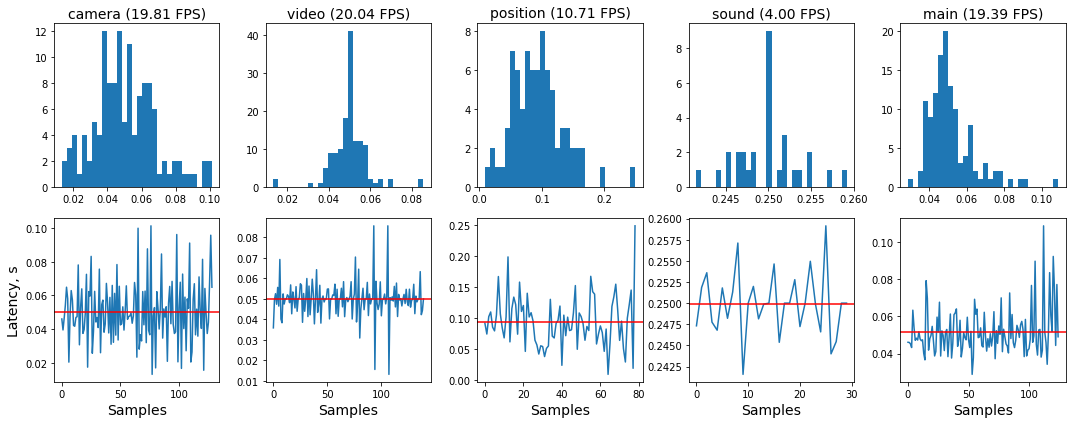

In [22]:
names = ['camera', 'video', 'position', 'sound', 'main']
ctrls = [vs, vw, pt, sc, fps]

fig, axes = plt.subplots(2, len(ctrls), figsize=(15,6))

for i, ctrl in enumerate(ctrls):
    diffs = ctrl.get_time_diffs()
    
    # latency histograms
    axes[0][i].hist(diffs, 30)
    axes[0][i].set_title('%s (%.2f FPS)' % (names[i], 1.0/diffs.mean()), fontsize=14)
    
    # latency plots
    axes[1][i].plot(diffs)
    axes[1][i].axhline(diffs.mean(), color='red')
    axes[1][i].set_xlabel('Samples', fontsize=14)
    if i == 0:
        axes[1][i].set_ylabel('Latency, s', fontsize=14)
    
fig.tight_layout()